***importing packages and libraries***

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomZoom
import pathlib as pl
import xml.etree.ElementTree as ET
from configs import modelConfigs

In [2]:
def pre_process_image(image, target_height, target_width):
    # Load image
    if isinstance(image, str):
        # If image is a file path, read and decode it
        image = tf.io.read_file(image)
        image = tf.image.decode_image(image, channels=3)  # Decode to RGB

    # Print shape before processing
    print("Original shape:", tf.shape(image))

    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    # Print shape after grayscale conversion
    print("After grayscale:", tf.shape(image))

    # Resize image
    image_resized = tf.image.resize_with_pad(image, target_height, target_width)
    
    # Print shape after resizing
    print("After resize:", tf.shape(image_resized))

    # Convert image to float32 and normalize to [0, 1]
    n_image = tf.image.convert_image_dtype(image_resized, tf.float32)
    
    # Print final shape
    print("Final shape:", tf.shape(n_image))

    return n_image

In [3]:
# a function to seperate the forms iamges computer text written parts from the hand written parts
# important as label would need to be doubled to train both parts and other training complications
# the name portion is also needs to be removed as their is not training data on the text
def forms_text_seporator(form_path, HW_bounding_box):
    image = tf.io.read_file(form_path)
    image = tf.io.decode_image(image, channels=3)

    # configs for dimensions
    c = modelConfigs()
    # standardise handwritten bouding box coords for tensorflow
    for i in range(4):
        if i % 2 == 0:
            HW_bounding_box[i] = HW_bounding_box[i] / c.form_height
        else:
            HW_bounding_box[i] = HW_bounding_box[i] / c.form_width

    # handwritten part
    HW_y1, HW_x1, HW_y2, HW_x2 = HW_bounding_box
    CW_bounding_box = [0, 0, HW_y2 , 1 ]

    HW_output_dimensions = [
        # ensure to round to or cast to not have floaring point vals
        tf.cast(c.form_height - c.form_height * (HW_y1 + HW_y2), tf.int32),
        tf.cast(c.form_width - c.form_width * (HW_x1 +  HW_x2), tf.int32)
    ]

    CW_output_dimensions = [
        # ensure to round to or cast to not have floating point vals
        tf.cast(c.form_height * HW_y2 , tf.int32),
        tf.cast(c.form_width, tf.int32)
    ]

    HW_cropped_image = tf.image.crop_and_resize([image], [HW_bounding_box], [0], HW_output_dimensions)
    CW_cropped_image = tf.image.crop_and_resize([image], [CW_bounding_box], [0], CW_output_dimensions)
    
    return HW_cropped_image[0], CW_cropped_image[0]

In [20]:
# TODO add more severe augmentations
def build_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        RandomBrightness(factor=(-0.1, 0.1), value_range=(0, 1)),
        RandomContrast(factor=0.5),
        RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant', fill_value=1.0)     
    ])
    return augmentation_model

def random_pad(image, max_padding=50):
    if isinstance(image, str):
        # If image is a file path, read and decode it
        image = tf.io.read_file(image)
        image = tf.image.decode_image(image, channels=3)
        
    elif isinstance(image, tf.Tensor):
        # If it's a tensor, ensure it's 3D and uint8
        if len(tf.shape(image)) == 4:
            image = tf.squeeze(image, axis=0)  # Remove batch dimension if present
        if image.dtype != tf.uint8:
            image = tf.cast(tf.clip_by_value(image * 255, 0, 255), tf.uint8)
    else:
        raise ValueError("Input must be a tensor or a file path string")

    # Ensure image is a 3D tensor (height, width, channels)
    if len(tf.shape(image)) == 2:
        image = tf.expand_dims(image, -1)

    # Get current image shape
    height, width, channels = tf.unstack(tf.shape(image))
    
    # Generate random padding
    pad_top = tf.random.uniform([], minval=0, maxval=max_padding, dtype=tf.int32)
    pad_bottom = tf.random.uniform([], minval=0, maxval=max_padding, dtype=tf.int32)
    pad_left = tf.random.uniform([], minval=0, maxval=max_padding, dtype=tf.int32)
    pad_right = tf.random.uniform([], minval=0, maxval=max_padding, dtype=tf.int32)
    
    # Create padding tensor
    paddings = [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]
    
    # Pad the image
    padded_image = tf.pad(image, paddings, mode='CONSTANT')
    
    return padded_image

def form_pad_val_gen():
    return tf.random.uniform([], minval=100, maxval=250, dtype=tf.int32)

def line_pad_val_gen():
    return tf.random.uniform([], minval=20, maxval=70, dtype=tf.int32)


In [5]:
#a function to update the form croping bouding box based on new data from new line
def form_crop_bouding_box_updater(current_bounding_box, line, line_num, total_lin_num):
    
    words = line.findall('word')
    for word in words:
        chars = word.findall('cmp')
        for char in chars:
            # first x coord
            x_val = int(char.get('x'))
            if current_bounding_box[1] > x_val:
                current_bounding_box[1] = x_val
            #  second x coord 
            if current_bounding_box[3] == 0:
                current_bounding_box[3] = x_val
            elif current_bounding_box[3] < x_val:
                current_bounding_box[3] = x_val
            # handling y coords cases
            y_val = int(char.get('y'))
            if line_num == 0:
                if current_bounding_box[0] > y_val:
                    current_bounding_box[0] = y_val
                    
            elif line_num == total_lin_num:
                if current_bounding_box[2] == 0:
                    current_bounding_box[2] = y_val
                elif current_bounding_box[2] < y_val:
                    current_bounding_box[2] = y_val
    return current_bounding_box


In [9]:
# TODO set appropriate defult image heights and width
def data_preparator(X_image_paths, Y_image_path , data_length = 1000 , image_target_height = 512, image_target_width = 1024, augmentation_probability = 0.3):
    # directory containing labels for training data
    label_dir = pl.Path(Y_image_path)
    # forms and lines paths
    forms_path = X_image_paths[0]
    lines_path = X_image_paths[1]
    # training example and label data X and Y
    X = []
    Y = []
    # keep track of the number files are being added to the data batch
    data_counter = 0
    # data augmentor
    base_augmentation_model = build_augmentation_model()

    for XML_path in label_dir.iterdir():
        if data_counter >= data_length:
            break
        # get XML root element 
        root = ET.parse(str(XML_path)).getroot()
        # a lines in the XML file
        all_line_ele = root.find('handwritten-part')
        lines = all_line_ele.findall('line')
        # get bounding boxes for handwritten part 
        # bouding box in the convention [y1, x1, y2, x2]
        form_crop_bounding_box = [0] * 4
        form_full_text = '' # will be added onto this string 
        line_counter = 0
        line_nums = len(lines) - 1 # the number of lines
        # sub foilder for form that contains the lines for that form
        subf_path = root.get('id')

        # for lines
        for line in lines:
            
            line_text = line.get('text') #TODO figure out how to make into sequence label
            form_full_text += line_text

            # image path in the subfolder
            image_subf_path = line.get('id')
            # sulber folder name (is the first 3 chars)
            subf_name = image_subf_path[:3]
            
            full_line_image_path = f'{lines_path}/{subf_name}/{subf_path}/{image_subf_path}.png'
            #process the image 
            line_image = random_pad(full_line_image_path)
            line_image = pre_process_image(line_image, image_target_height, image_target_width)
            #randomly with a chosen probability augment
            if np.random.rand() < augmentation_probability:
                line_image = base_augmentation_model(line_image)
            X.append(line_image)
            data_counter += 1
            
            form_crop_bounding_box = form_crop_bouding_box_updater(
                form_crop_bounding_box,
                line,
                line_counter,
                line_nums
            )
            line_counter += 1
        print(subf_path)
        full_form_image_path = f'{forms_path}/{subf_path}.png'
        # get computer generated 
        CW_cropped_form_image, HW_cropped_form_image = forms_text_seporator(
            full_form_image_path, 
            form_crop_bounding_box
        )
        # randomly pad all form image for richer training data
        CW_form_image = random_pad(CW_cropped_form_image, form_pad_val_gen())
        HW_form_image = random_pad(HW_cropped_form_image, form_pad_val_gen())

        CW_form_image = pre_process_image(CW_cropped_form_image, image_target_height, image_target_width)
        HW_form_image = pre_process_image(HW_cropped_form_image, image_target_height, image_target_width)

        if np.random.rand() < augmentation_probability:
            CW_form_image = base_augmentation_model(CW_form_image)
            HW_form_image = base_augmentation_model(HW_form_image)

        X.append(HW_form_image)
        X.append(CW_form_image)

        data_counter += 2
        
    """
    TODO figure how to stop inputs at exactly the right amount although it shouldnt matter to much as keras should handle extra data 
    TODO figure out sequence dat a using the string ouputs we have 
    """
    return np.array(X)



In [21]:
c = modelConfigs()

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit to 6GB (6144 MB)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)




X = data_preparator(c.image_paths, c.label_path, data_length = 2 )
print(X)
print("Number of images:", len(X))
print("Shape of first image:", X[0].shape)
print("Data type of first image:", X[0].dtype)
for i in range(min(5, len(X))):
    print(f"Shape of image {i}:", X[i].shape)

Original shape: tf.Tensor([ 182 1882    3], shape=(3,), dtype=int32)
After grayscale: tf.Tensor([ 182 1882    1], shape=(3,), dtype=int32)
After resize: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Final shape: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Original shape: tf.Tensor([ 176 1880    3], shape=(3,), dtype=int32)
After grayscale: tf.Tensor([ 176 1880    1], shape=(3,), dtype=int32)
After resize: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Final shape: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Original shape: tf.Tensor([ 200 1851    3], shape=(3,), dtype=int32)
After grayscale: tf.Tensor([ 200 1851    1], shape=(3,), dtype=int32)
After resize: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Final shape: tf.Tensor([ 512 1024    1], shape=(3,), dtype=int32)
Original shape: tf.Tensor([ 177 1858    3], shape=(3,), dtype=int32)
After grayscale: tf.Tensor([ 177 1858    1], shape=(3,), dtype=int32)
After resize: tf.Tensor([ 512 1024    1], sha

In [16]:
!pip install nbformat
%run 'tester_functions.ipynb'

Matplotlib is building the font cache; this may take a moment.


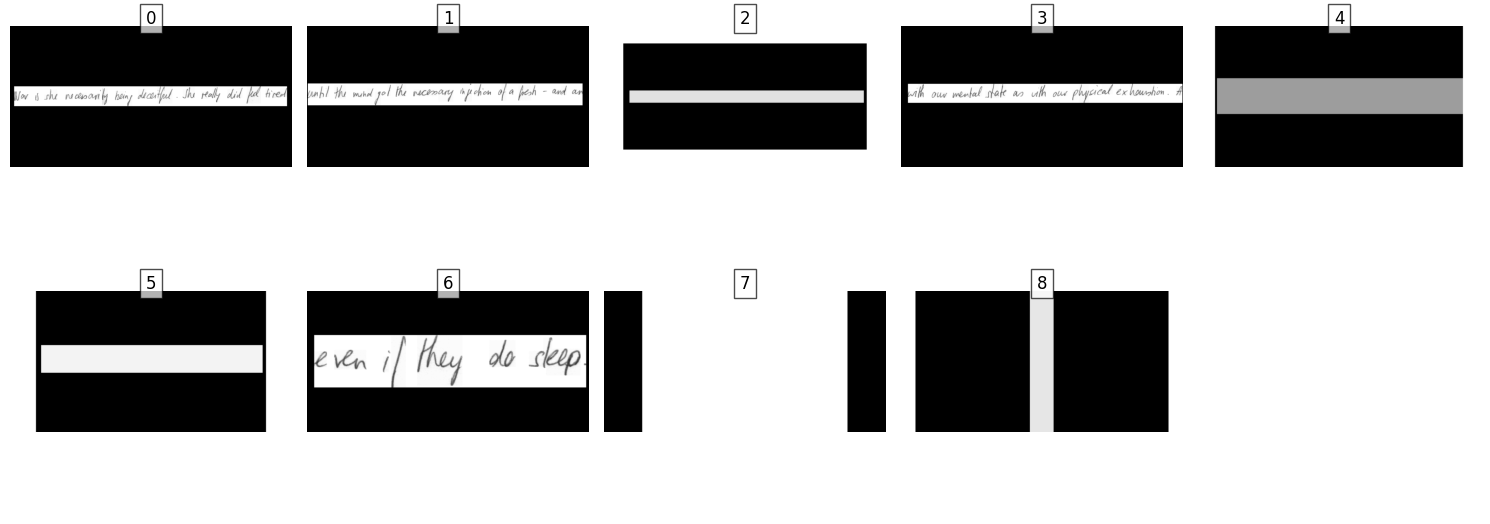

In [22]:
inpute_batch_displayer(X)